In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-07-25 21:10:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  29.3MB/s    in 2.2s    

2021-07-25 21:10:47 (29.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

In [3]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

## Primero como siempre importamos los datos

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Ahora importamos la red y los pesos de la red VGG16

In [5]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [6]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Setear los parámetros del modelo base a no entrenable

In [7]:
vgg_base.trainable=False 

### Ahora hay que agregar las últimas capas de la red:

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg_base)
# agregar el final de la red
# una capa flatten
# una capa densa de 256 elementos
# una capa sigmoidea
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Entrenamos el modelo

In [9]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 647s 6s/step - loss: 0.5822 - acc: 0.6985 - val_loss: 0.4571 - val_acc: 0.7980
Epoch 2/3
100/100 [==============================] - 644s 6s/step - loss: 0.4800 - acc: 0.7870 - val_loss: 0.3722 - val_acc: 0.8400
Epoch 3/3
100/100 [==============================] - 644s 6s/step - loss: 0.4270 - acc: 0.8130 - val_loss: 0.3338 - val_acc: 0.8550


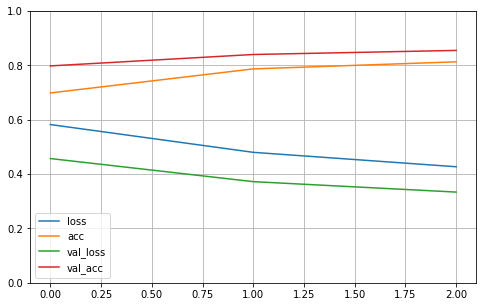

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# TAREA: Hacer lo mismo con ResNet50:

In [14]:
from tensorflow.keras.applications import ResNet50

# https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

base_resnet = ResNet50(
    include_top=False,  # whether to include the fully-connected layer at the top of the network.
    weights="imagenet", # one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
    input_tensor=None,  # optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
    input_shape=(150, 150, 3),
    pooling='avg',
    # Optional pooling mode for feature extraction when include_top is False.
    #     None means that the output of the model will be the 4D tensor output of the last convolutional block.
    #     avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
    #     max means that global max pooling will be applied.
    
    #classes=1000, # 	optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.
    # **kwargs
)

### COMPLETAR

94773248/94765736 [==============================] - 2s 0us/step


In [15]:
model_rn50 = models.Sequential()
model_rn50.add(base_resnet)
# agregar el final de la red
# una capa flatten
# una capa densa de 256 elementos
# una capa sigmoidea
model_rn50.add(layers.Flatten())
model_rn50.add(layers.Dense(256, activation='relu'))
model_rn50.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model_rn50.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
history_rn50 = model_rn50.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 865s 9s/step - loss: 0.3238 - acc: 0.8610 - val_loss: 0.6954 - val_acc: 0.5040
Epoch 2/3
100/100 [==============================] - 858s 9s/step - loss: 0.1577 - acc: 0.9370 - val_loss: 0.6972 - val_acc: 0.5130
Epoch 3/3
100/100 [==============================] - 854s 9s/step - loss: 0.1208 - acc: 0.9560 - val_loss: 1.2898 - val_acc: 0.5000


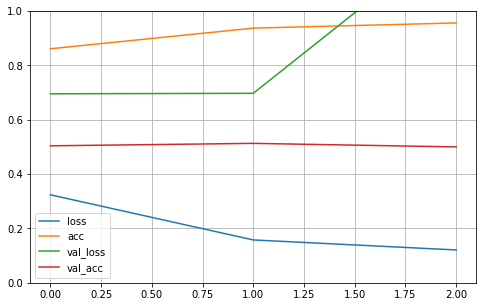

In [18]:
pd.DataFrame(history_rn50.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()